<a href="https://colab.research.google.com/github/brenddonandrade/ShortPaperGEOINFO2023/blob/main/Communicability_short_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Necessary Installations and Imports

In [ ]:
!pip install osmnx

In [ ]:
import networkx as nx
import numpy as np
from math import factorial
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import scipy as sp
import csv
import time
import osmnx as ox
import copy
from shapely.constructive import normalize
import requests
from io import StringIO

# Proposed Method

In [ ]:
def communicability(adj_matrix, n):
    '''
    Parameters
    ----------
    adj_matrix: numpy ndarray
        the adjacency matrix of the graphs

    n: int
        number of terms to be considered in the series

    '''

    matrix_1 = adj_matrix.copy()
    matrix_2 = adj_matrix.copy()
    matrix_3 = adj_matrix.copy()
    matrix_c = np.identity(len(adj_matrix), float)
    matrix_c = matrix_c + matrix_1

    for k in range(2,n+1):

        # Raise the matrix by k
        matrix_1 = np.dot(matrix_1, matrix_2)
        matrix_3 = matrix_1/factorial(k)

        # Sum the n matrices
        matrix_c = matrix_c + matrix_3
        # matrix_c += matrix_3

    return matrix_c

In [ ]:
# assigning the measure of the graph
def attr_communicability_nx(graph):
    dict_com = {}

    com = nx.communicability_exp(graph)

    for node_p, nodes_values in com.items():
        let_com = 0
        for node_q, com_value in nodes_values.items():
            let_com = let_com + com_value

        dict_com[node_p] = let_com


    nx.set_node_attributes(graph, values=dict_com, name="com")

# Dependency

## Transform Dict from NetworkX to Numpy Array

In [ ]:
def nx_to_np(dict_comunica):
    nodes = dict_comunica.__len__()
    matrix_c = np.zeros((nodes, nodes), float)

    for node_i, nodedict in dict_comunica.items():
        for node_j, value in nodedict.items():
            matrix_c[node_i][node_j] = value

    return matrix_c

## Create matrix adjacency

In [ ]:
# k_star is the k with property that communicability is 95% compared to other methods
def find_k_star(G):

    nodelist = list(G)
    A = nx.to_numpy_array(G, nodelist)

    # convert to 0-1 matrix
    A[A != 0.0] = 1
    # communicability matrix
    matrix_com_1 = sp.linalg.expm(A)


    # Mean of communicability matrix
    mean_1 = matrix_com_1.mean()
    list_comparation = []


    matrix_adj = nx.adjacency_matrix(G).todense()


    k_star = 0
    for i in range(1, K+1):
        matrix_com_2 = communicability(matrix_adj, i)
        mean_2 = matrix_com_2.mean()
        list_comparation.append(compare_values(mean_2, mean_1))
        if list_comparation[i-1] > EQUIVALENCE:
            k_star = i
            break
        if i > (K-1) and k_star == 0 :
            print('\n\n!!!NOT FOUND: k_star\n\n')


    return k_star

## Find Density and edges for to maintain density



In [ ]:
def find_density(nodes, edges):
    density = 2 * edges/(nodes * (nodes - 1))
    return density

def find_number_edges(density, nodes):
    return int(density*nodes*(nodes-1)/2)

## Comparation

In [ ]:
def compare_values(value_1, value_2):
    comparation = (value_1/value_2)*100
    return comparation

## The cost of the time


In [ ]:
# Measure time of spectral method
def method_1_cost(G):

    print('Method cost: communicability(nx)')
    time_start = time.time()
    for i in range(NUMBER_OF_MEASURES):
        time_start_in = time.time()
        nx.communicability(G)
        time_end_in = time.time()
        print(f'Measures: {i+1}\nTime: {(time_end_in - time_start_in):.2f}s')

    time_end = time.time()

    print(f'Total time Spectral: {(time_end - time_start):.2f}s')

    print('\n')


    mean_time = (time_end - time_start)/NUMBER_OF_MEASURES
    cost = mean_time
    return cost


# Measure time of exponential method
def method_2_cost(G):
    print('Method cost: communicability_exp(nx)')
    time_start = time.time()
    for i in range(NUMBER_OF_MEASURES):
        time_start_in = time.time()
        nx.communicability_exp(G)
        time_end_in = time.time()
        print(f'Measures: {i+1}\nTime: {(time_end_in - time_start_in):.2f}s')

    time_end = time.time()

    print(f'Total time Exponential: {(time_end - time_start):.2f}s')
    print('\n')


    cost = mean_time = (time_end - time_start)/NUMBER_OF_MEASURES


    return cost

# Measure time of serie method
def method_3_cost_k_star(G):

    print('Method cost: communicability(me)')
    time_start = time.time()
    matrix_adj = nx.adjacency_matrix(G).todense()
    k = find_k_star(G)
    for i in range(NUMBER_OF_MEASURES):
        time_start_in = time.time()
        matrix_c = communicability(matrix_adj, k)
        time_end_in = time.time()

        print(f'Measures: {i+1}\nTime: {(time_end_in - time_start_in):.2f}s')


    time_end = time.time()
    print(f'Total time series: {(time_end - time_start):.2f}s')
    print('\n')


    mean_time = (time_end - time_start)/NUMBER_OF_MEASURES

    cost = mean_time
    return cost

## Methods Relation

makes the relationship between the means of the communicability matrix provided by the methods to find $k^*$.

\begin{equation}
    \frac{(<Com>)^*_{serie}}{(<Com>)_{reference}} \geq 95\%
\end{equation}

In [ ]:
# ratio serie/spectral
def methods_ratio_1(G):

    list_ratio = []
    com_1 = nx_to_np(nx.communicability(G))
    mean_1 = com_1.mean()


    matrix_adj = nx.adjacency_matrix(G).todense()
    for i in range(1, POINTS+1):
        matrix_c = communicability(matrix_adj, i)
        mean = matrix_c.mean()
        list_ratio.append(compare_values(mean, mean_1))


    return list_ratio

# ratio serie/exponential
def methods_ratio_2(G):
    list_ratio = []
    com_2 = nx_to_np(nx.communicability_exp(G))
    mean_2 = com_2.mean()


    matrix_adj = nx.adjacency_matrix(G).todense()
    for i in range(1, POINTS+1):
        matrix_c = communicability(matrix_adj, i)
        mean = matrix_c.mean()
        list_ratio.append(compare_values(mean, mean_2))

    return list_ratio


## Creating the data

In [ ]:
def time_cost_road_networks(center_point, max_radius):
    '''
    Parameters
    ----------
    center_point: tuple
        latitude and longitude of the center ponit of the box

    max_radius: int
        maximum radius to consider when creating the network

    '''

    # find interval
    interval = max_radius//POINTS
    radius = interval

    # Data
    data_cost = {}
    list_data_time_1 = []
    list_data_time_2 = []
    list_data_time_3 = []
    list_data_k_star = []
    list_data_number_nodes = []
    list_data_number_edges = []
    list_data_density = []
    list_data_radius = []



    for size in range(radius, max_radius + interval, interval):

        print(f'radius: {size}')

        graph = ox.graph.graph_from_point(center_point, dist=size, dist_type='bbox', network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, custom_filter=None)


        graph = nx.Graph(graph)

        density = find_density(len(graph.nodes), len(graph.edges))

        time_3 = method_3_cost_k_star(graph)
        time_2 = method_2_cost(graph)
        time_1 = method_1_cost(graph)

        k_star = find_k_star(graph)

        list_data_time_1.append(time_1)
        list_data_time_2.append(time_2)
        list_data_time_3.append(time_3)
        list_data_k_star.append(k_star)
        list_data_number_nodes.append(len(graph.nodes))
        list_data_number_edges.append(len(graph.edges))
        list_data_density.append(density)
        list_data_radius.append(size)


    data_cost['Spectral'] = list_data_time_1
    data_cost['Exponential'] = list_data_time_2
    data_cost['Series'] = list_data_time_3
    data_cost['k*'] =  list_data_k_star
    data_cost['Nodes'] = list_data_number_nodes
    data_cost['Edges'] = list_data_number_edges
    data_cost['Density'] = list_data_density
    data_cost['Radius'] = list_data_radius


    df = pd.DataFrame(data_cost)

    return df

## Example

## Constants


In [ ]:
# Used constants and graphs

# Methods used
# Method 1: Spectral (nx.communicability(G))
# Method 2: Exponential (nx.communicability_exp(G))
# Method 3: Proposed method

# Max of terms considered
K = 100


# Equivalence
EQUIVALENCE = 95


# Mean to calculate time
NUMBER_OF_MEASURES = 20


# Network details
CENTER_POINT = (-23.546,-46.634)
MAX_RADIUS = 800

# Values for the 10 measures
POINTS  = 10

## Work with data


In [ ]:
def work_with_data(df, name_index = None):
    if (name_index == None):
        df_result = df.drop('Unnamed: 0', axis=1)
    else:
        df_result = df.drop('Unnamed: 0', axis=1)
        df_result.set_index(name_index, inplace=True)
    return df_result

## Plot data

In [ ]:
def plot_data(df, columns_name, name_x_axis, name_y_axis, title = None, scale = None, title_legend = None, marker_k = False, marker_value = 95, index = None):
    traces = []
    if index == None:
        for trace in columns_name:
            traces.append(go.Scatter(x=df.index, y = df[trace], mode='markers', name= trace))
    else:
        for trace in columns_name:
            traces.append(go.Scatter(x=df[index], y = df[trace], mode='markers', name= trace))

    fig = go.Figure(data=traces)

    fig.update_layout(
        title = {
            'text':  title,
            'font': {
                'size': 32,
                'family': 'Arial',
            },
            'x': 0.5
        },

        legend = {
            'title': {
                'text': title_legend,
                'font': {
                    'size': 24,
                    'family': 'Arial',
                },
            },
            'font': {
                'size': 20,
                'family': 'Arial',
            },
        },


        xaxis_title_text= name_x_axis,
        yaxis_title_text= name_y_axis,

        width = 800,
        height= 600
    )

    # Marker k*
    if marker_k == True:
        k = 0
        for value in df['Series-Spectral']:
            k = k +1
            if value > marker_value:
                pos_x = k
                pos_y = value
                break

        fig.add_trace(
            go.Scatter(
                name = 'k*',
                x= [pos_x],
                y= [pos_y],
                mode='markers',
                marker=dict(size=22,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                showlegend=False,
            )
        )

        fig.update_traces(marker=dict(size=8))
        fig.add_annotation(
            x = pos_x,
            y = pos_y,
            text = f'k*: {pos_x}',
            font = {
                'size': 24,
                'family': 'Arial',
            },

            showarrow=True,
            arrowhead=1,
        )

    # Retired the grid
    fig.update_xaxes (
        showgrid=True,
        title_font = dict(
            size= 24,
            family= 'Arial'),
        tickfont=dict(
            size=20),
        ticks = 'inside',
        nticks = len(df.index)
        )
    fig.update_yaxes (
        showgrid=True,
        title_font = dict(
            size= 24,
            family= 'Arial'),
        type = scale,
        tickfont=dict(
            size=20),
        ticks = 'inside',
        dtick=1
        )

    fig.update_layout(showlegend=True)
    fig.show()

## How much is fastest?

In [ ]:
def fastest(df):

    list_spectral_series = []
    list_exponential_series = []
    list_series_exponential = []
    list_spectral_exponential = []
    for nodes in df.index:
        list_spectral_series.append(df['Spectral'][nodes]/df['Series'][nodes])
        list_exponential_series.append(df['Exponential'][nodes]/df['Series'][nodes])
        list_series_exponential.append(df['Series'][nodes]/df['Exponential'][nodes])
        list_spectral_exponential.append(df['Spectral'][nodes]/df['Exponential'][nodes])

    df['Spectral/Series'] = list_spectral_series
    df['Exponential/Series'] = list_exponential_series
    df['Series/Exponential'] = list_series_exponential
    df['Spectral/Exponential'] = list_spectral_exponential

    return df

## Real Networks

### Generating your data

In [ ]:
# If you want to generate your own data, run this cell
df_1 = time_cost_road_networks(CENTER_POINT, MAX_RADIUS)

# save data
df_1.to_csv('df_time.csv')
df_time = pd.read_csv('df_time.csv')
df_time = work_with_data(df_time, 'Nodes')

radius: 120
Method cost: communicability(me)
Measures: 1
Time: 0.00s
Total time series: 0.00s


Method cost: communicability_exp(nx)
Measures: 1
Time: 0.00s
Total time Exponential: 0.00s


Method cost: communicability(nx)
Measures: 1
Time: 0.01s
Total time Spectral: 0.01s


radius: 240
Method cost: communicability(me)
Measures: 1
Time: 0.00s
Total time series: 0.01s


Method cost: communicability_exp(nx)
Measures: 1
Time: 0.00s
Total time Exponential: 0.01s


Method cost: communicability(nx)
Measures: 1
Time: 0.33s
Total time Spectral: 0.33s


radius: 360
Method cost: communicability(me)
Measures: 1
Time: 0.07s
Total time series: 0.50s


Method cost: communicability_exp(nx)
Measures: 1
Time: 0.09s
Total time Exponential: 0.10s


Method cost: communicability(nx)
Measures: 1
Time: 9.58s
Total time Spectral: 9.59s


radius: 480
Method cost: communicability(me)
Measures: 1
Time: 1.07s
Total time series: 5.88s


Method cost: communicability_exp(nx)
Measures: 1
Time: 0.33s
Total time Exponen

## Nodes x Cost time

In [ ]:
# your data
df_time

,Spectral,Exponential,Series,k*,Edges,Density,Radius
Nodes,,,,,,,
13,0.013778,0.002519,0.003183,5,13,0.166667,120
52,0.331571,0.005011,0.008089,6,65,0.049020,240
155,9.585070,0.096708,0.498452,6,219,0.018349,360
380,62.735230,0.331633,5.877861,7,569,0.007902,480
666,325.592818,0.860769,15.560535,7,1007,0.004547,600


In [ ]:
columns = ['Spectral', 'Exponential', 'Series']
plot_data(df_time, columns, 'Nodes', 'Log[ Tempo(s) ]', scale = 'log')

### Geografo -> Simple Graph with attributes

In [ ]:
def create_graph(graph):
    # Multigraph -> Simple graph
    graph = nx.Graph(graph)

    # Assigning communicability values
    attr_communicability_nx(graph)

    return graph

### Plotting Network

In [ ]:
# Plotting
def plot_graph_for_node(graph, attribute, name = None):

    if name == None:
        name = attribute

    # get colors
    cmap = 'plasma'

    graph = nx.MultiGraph(graph)

    nc = ox.plot.get_node_colors_by_attr(graph, attr=attribute , cmap=cmap)
    norm = mpl.colors.Normalize(vmin=np.min(list(nx.get_node_attributes(graph, attribute).values())),
                                vmax=np.max(list(nx.get_node_attributes(graph, attribute).values())))

    # plot graph and add colorbar
    fig, ax = ox.plot_graph(graph, edge_linewidth=0.3, node_size=10, node_color=nc, show=False, bgcolor='#FFFFFF')
    fig.set_size_inches(10, 7)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label = name)
    fig.savefig(f'{name}.png', dpi=300, format='png')

### Create data

In [ ]:
# Getting Street Networks
G = ox.graph.graph_from_point(CENTER_POINT, dist=MAX_RADIUS, dist_type='bbox', network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, custom_filter=None)

# Works the graph to generate a simple graph
graph = create_graph(G)

### Plot the communicability of the Road Network


<ipython-input-48-dcb83c0a973d>:19: MatplotlibDeprecationWarning:

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.



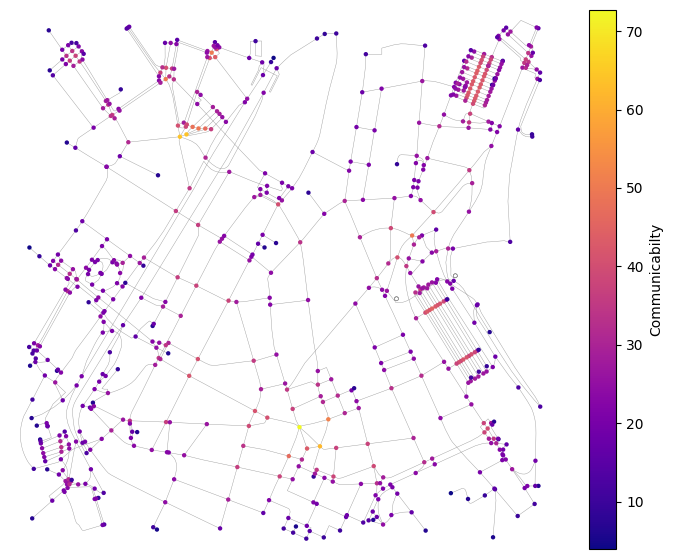

In [ ]:
plot_graph_for_node(graph, 'com', 'Communicabilty')

### Getting my data

In [ ]:
# Getting file
github_csv_url = "https://raw.githubusercontent.com/brenddonandrade/ShortPaperGEOINFO2023/main/data_short_paper.csv"
response = requests.get(github_csv_url)

# Check if you can get the file
if response.status_code == 200:
    csv_data = response.text
    csv_buffer = StringIO(csv_data)
    df = pd.read_csv(csv_buffer)
else:
    print("Falha ao obter o arquivo CSV do GitHub. Código de status:", response.status_code)

In [ ]:
# work the file to analyze
df_2 = work_with_data(df, 'Nodes')
df_2 = fastest(df)

In [ ]:
df_2

,Unnamed: 0,Spectral,Exponential,Series,k*,Nodes,Edges,Density,Spectral/Series,Exponential/Series,Series/Exponential,Spectral/Exponential
0,0,0.069015,0.001609,0.002693,6,28,34,0.089947,25.624400,0.597454,1.673769,42.889320
1,1,0.258204,0.007777,0.004744,6,63,84,0.043011,54.424649,1.639315,0.610011,33.199630
2,2,0.783030,0.016191,0.019768,6,100,138,0.027879,39.611735,0.819074,1.220890,48.361587
3,3,4.747112,0.049835,0.061484,6,188,260,0.014791,77.208354,0.810524,1.233769,95.257284
4,4,16.503549,0.113249,0.201913,6,285,410,0.010131,81.735949,0.560882,1.782905,145.727414
5,5,54.335944,0.190311,0.781023,7,422,625,0.007036,69.570263,0.243669,4.103936,285.511886
6,6,151.403308,0.303862,2.745383,7,592,892,0.005099,55.148342,0.110681,9.034970,498.263619
7,7,258.897781,0.436939,6.443937,7,710,1079,0.004287,40.176957,0.067806,14.747896,592.525562
8,8,412.713150,0.566143,10.493963,7,826,1270,0.003727,39.328625,0.053949,18.535882,728.990766
9,9,616.754816,0.722417,24.580868,7,957,1483,0.003242,25.090848,0.029389,34.025862,853.737710


In [ ]:
# Create the time graphic
columns = ['Spectral', 'Exponential', 'Series']
plot_data(df_2, columns, 'Nodes', 'Log[ Tempo(s) ]', scale = 'log')